# 1. Setup and Get Data

### 1.1 Install Dependencies and Setup

In [ ]:
!pip install labelme tensorflow tensorflow-gpu opencv-python matplotlib albumentations

### 1.2 Collect Images Using OpenCV

In [1]:
import os

In [18]:
!pip install --upgrade opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 60.9 MB 112 kB/s 
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30


In [2]:
import time
import uuid
import cv2

In [3]:
IMAGES_PATH = os.path.join('content','data','images')
number_images = 30

In [ ]:
cap = cv2.VideoCapture(1)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

### 1.3 Annotate Images with LabelMe

In [ ]:
!labelme

# 2. Review Dataset and Build Image Loading Function

### 2.1 Import TF and Deps

In [4]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 2.3 Load Image into TF Data Pipeline

In [5]:
images = tf.data.Dataset.list_files('/content/drive/MyDrive/data/images/*.jpg')

In [6]:
images.as_numpy_iterator().next()

b'/content/drive/MyDrive/data/images/8eabb682-f21d-11ec-a882-a02bb82c8c11.jpg'

In [7]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [8]:
images = images.map(load_image)

In [9]:
images.as_numpy_iterator().next()

array([[[248, 255, 255],
        [249, 255, 255],
        [249, 255, 255],
        ...,
        [111,  99,  85],
        [109,  97,  81],
        [110,  98,  82]],

       [[246, 255, 254],
        [247, 255, 255],
        [249, 255, 255],
        ...,
        [110,  98,  84],
        [108,  96,  82],
        [109,  97,  81]],

       [[247, 255, 255],
        [249, 255, 255],
        [250, 255, 255],
        ...,
        [109,  97,  83],
        [106,  97,  82],
        [106,  97,  82]],

       ...,

       [[112, 121, 130],
        [115, 125, 134],
        [123, 133, 142],
        ...,
        [ 18,  22,  31],
        [ 18,  22,  33],
        [ 18,  22,  33]],

       [[109, 118, 127],
        [115, 125, 134],
        [122, 132, 141],
        ...,
        [ 17,  21,  30],
        [ 17,  21,  32],
        [ 17,  21,  32]],

       [[116, 125, 134],
        [118, 128, 137],
        [123, 133, 142],
        ...,
        [ 16,  20,  29],
        [ 16,  20,  31],
        [ 16,  20,  31]]

In [10]:
type(images)

tensorflow.python.data.ops.dataset_ops.MapDataset

### 2.4 View Raw Images with Matplotlib

In [11]:
image_generator = images.batch(4).as_numpy_iterator()

In [12]:
plot_images = image_generator.next()

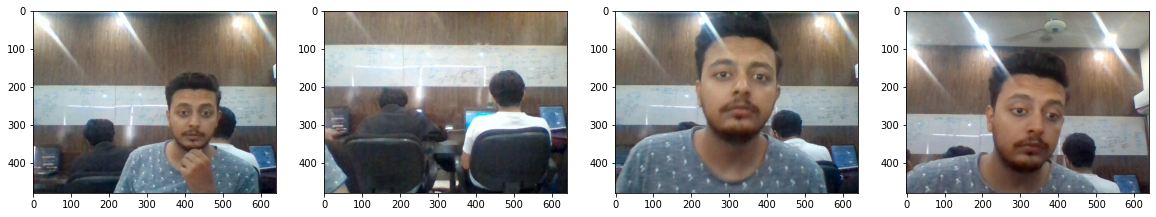

In [13]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

# 3. Partition Unaugmented Data

### 3.1 MANUALLY SPLT DATA INTO TRAIN TEST AND VAL

In [ ]:
90*.7 # 63 to train

In [ ]:
90*.15 # 14 and 13 to test and val

### 3.2 Move the Matching Labels

In [14]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('/content/drive/MyDrive/data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('/content/drive/MyDrive/data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('/content/drive/MyDrive/data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)      

# 4. Apply Image Augmentation on Images and Labels using Albumentations

### 4.1 Setup Albumentations Transform Pipeline

In [14]:
import albumentations as alb

In [15]:
!pip install --upgrade albumentations

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [16]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                         bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

### 4.2 Load a Test Image and Annotation with OpenCV and JSON

In [17]:
img = cv2.imread(os.path.join('/content/drive/MyDrive/data','train', 'images','54bda661-f21d-11ec-84c0-a02bb82c8c11.jpg'))

In [18]:
with open(os.path.join('/content/drive/MyDrive/data', 'train', 'labels', '54bda661-f21d-11ec-84c0-a02bb82c8c11.json'), 'r') as f:
    label = json.load(f)

In [19]:
label['shapes'][0]['points']

[[176.1428571428571, 194.28571428571428],
 [391.1428571428571, 472.1428571428571]]

### 4.3 Extract Coordinates and Rescale to Match Image Resolution

In [20]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [21]:
coords

[176.1428571428571, 194.28571428571428, 391.1428571428571, 472.1428571428571]

In [22]:
coords = list(np.divide(coords, [640,480,640,480]))

In [23]:
coords

[0.2752232142857142,
 0.40476190476190477,
 0.6111607142857143,
 0.9836309523809523]

### 4.4 Apply Augmentations and View Results

In [24]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [25]:
augmented

{'bboxes': [(0.16031746031746025, 0.3850793650793651, 0.638095238095238, 1.0)],
 'class_labels': ['face'],
 'image': array([[[ 80,  80,  80],
         [ 80,  80,  80],
         [ 80,  81,  79],
         ...,
         [ 84,  87,  91],
         [ 84,  87,  91],
         [ 84,  87,  91]],
 
        [[ 82,  80,  79],
         [ 82,  80,  79],
         [ 81,  82,  80],
         ...,
         [ 86,  89,  93],
         [ 86,  89,  93],
         [ 86,  89,  93]],
 
        [[ 81,  79,  78],
         [ 82,  80,  79],
         [ 81,  82,  80],
         ...,
         [ 87,  90,  94],
         [ 87,  90,  94],
         [ 87,  90,  94]],
 
        ...,
 
        [[ 45,  33,  27],
         [ 46,  34,  28],
         [ 48,  36,  30],
         ...,
         [137, 127, 117],
         [137, 127, 117],
         [138, 128, 118]],
 
        [[ 43,  31,  25],
         [ 44,  32,  26],
         [ 46,  34,  28],
         ...,
         [136, 126, 116],
         [136, 126, 116],
         [136, 126, 116]],
 
    

In [26]:
augmented['bboxes'][0][2:]

(0.638095238095238, 1.0)

In [27]:
augmented['bboxes'][0][:2]

(0.16031746031746025, 0.3850793650793651)

In [28]:
augmented['bboxes']

[(0.16031746031746025, 0.3850793650793651, 0.638095238095238, 1.0)]

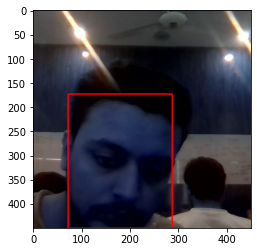

In [29]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

# 5. Build and Run Augmentation Pipeline

### 5.1 Run Augmentation Pipeline

In [46]:
#import shutil
#shutil.rmtree('/content/drive/MyDrive/data/aug_data/val/labels')

In [30]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('/content/drive/MyDrive/data', partition, 'images')):
        img = cv2.imread(os.path.join('/content/drive/MyDrive/data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('/content/drive/MyDrive/data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('/content/drive/MyDrive/data/aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('/content/drive/MyDrive/data/aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

x_max is less than or equal to x_min for bbox [0.22388392857142855, 0.31101190476190477, 0.0, 0.74375, 'face'].
x_max is less than or equal to x_min for bbox [0.9883928571428571, 0.3139880952380952, 0.6167410714285714, 0.9241071428571428, 'face'].
x_max is less than or equal to x_min for bbox [0.9906249999999999, 0.9925595238095237, 0.6089285714285714, 0.306547619047619, 'face'].
x_max is less than or equal to x_min for bbox [0.14464285714285713, 0.39285714285714285, 0.00401785714285714, 0.8288690476190476, 'face'].
x_max is less than or equal to x_min for bbox [0.07656249999999998, 0.8497023809523809, 0.0029017857142857096, 0.41815476190476186, 'face'].
x_max is less than or equal to x_min for bbox [0.9962053571428571, 0.41071428571428564, 0.6156249999999999, 0.9761904761904762, 'face'].
x_max is less than or equal to x_min for bbox [0.16696428571428568, 0.369047619047619, 0.0006696428571428492, 0.7574404761904762, 'face'].
x_max is less than or equal to x_min for bbox [0.235044642857

### 5.2 Load Augmented Images to Tensorflow Dataset

In [31]:
train_images = tf.data.Dataset.list_files('/content/drive/MyDrive/data/aug_data/train/images/*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [32]:
test_images = tf.data.Dataset.list_files('/content/drive/MyDrive/data/aug_data/test/images/*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [33]:
val_images = tf.data.Dataset.list_files('/content/drive/MyDrive/data/aug_data/val/images/*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [34]:
train_images.as_numpy_iterator().next()

array([[[0.02892157, 0.02892157, 0.03186275],
        [0.02303922, 0.02401961, 0.05735294],
        [0.02634804, 0.05330882, 0.12634803],
        ...,
        [0.1622549 , 0.05637255, 0.02892157],
        [0.17058824, 0.05686275, 0.03333334],
        [0.17738971, 0.06366421, 0.0401348 ]],

       [[0.02775735, 0.02775735, 0.03033088],
        [0.02444853, 0.0278799 , 0.04993873],
        [0.01525735, 0.03431373, 0.10557598],
        ...,
        [0.16078432, 0.05490196, 0.02745098],
        [0.17984068, 0.07395833, 0.04650735],
        [0.17941177, 0.06862745, 0.04362745]],

       [[0.03137255, 0.03137255, 0.02647059],
        [0.03088235, 0.0278799 , 0.04767157],
        [0.01482843, 0.02738971, 0.084375  ],
        ...,
        [0.15343137, 0.05539216, 0.02794118],
        [0.18333334, 0.07745098, 0.05      ],
        [0.19430147, 0.08351716, 0.05851716]],

       ...,

       [[0.41930148, 0.3918505 , 0.36047795],
        [0.43382353, 0.40637255, 0.3759804 ],
        [0.422549  , 0

# 6. Prepare Labels

### 6.1 Build Label Loading Function

In [35]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

### 6.2 Load Labels to Tensorflow Dataset

In [37]:
train_labels = tf.data.Dataset.list_files('/content/drive/MyDrive/data/aug_data/train/labels/*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [38]:
test_labels = tf.data.Dataset.list_files('/content/drive/MyDrive/data/aug_data/test/labels/*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [39]:
val_labels = tf.data.Dataset.list_files('/content/drive/MyDrive/data/aug_data/val/labels/*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [40]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.515    , 0.0019045, 0.993    , 0.619    ], dtype=float16))

# 7. Combine Label and Image Samples

### 7.1 Check Partition Lengths

In [41]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(4500, 4500, 780, 780, 840, 840)

### 7.2 Create Final Datasets (Images/Labels)

In [42]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [43]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [44]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [45]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [0],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8), array([[0.8228, 0.3086, 1.    , 0.7246],
        [0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    ],
        [0.3926, 0.3196, 0.8813, 0.891 ],
        [0.669 , 0.1606, 0.9688, 0.6113],
        [0.624 , 0.33  , 1.    , 0.754 ],
        [0.    , 0.2937, 0.3254, 0.735 ],
        [0.593 , 0.3845, 0.925 , 0.6875]], dtype=float16))

### 7.3 View Images and Annotations

In [46]:
data_samples = train.as_numpy_iterator()

In [47]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


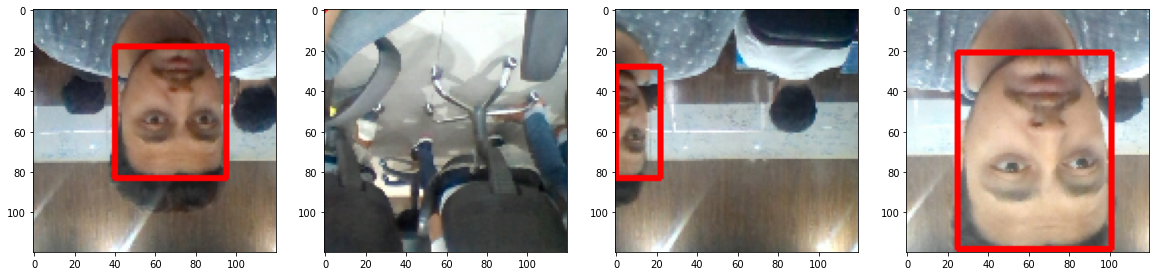

In [48]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

# 8. Build Deep Learning using the Functional API

### 8.1 Import Layers and Base Network

In [49]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

### 8.2 Download VGG16

In [50]:
vgg = VGG16(include_top=False)

58900480/58889256 [==============================] - 0s 0us/step


In [51]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

### 8.3 Build instance of Network

In [72]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

### 8.4 Test out Neural Network

In [73]:
facetracker = build_model()

In [74]:
facetracker.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_4[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d_2 (Global  (None, 512)         0           ['vgg16[0][0]']                  
 MaxPooling2D)                                                                              

In [75]:
X, y = train.as_numpy_iterator().next()

In [76]:
X.shape

(8, 120, 120, 3)

In [77]:
classes, coords = facetracker.predict(X)

In [78]:
classes, coords

(array([[0.4001061 ],
        [0.36917976],
        [0.38059774],
        [0.37697068],
        [0.41022423],
        [0.46927541],
        [0.40924877],
        [0.50091976]], dtype=float32),
 array([[0.46000808, 0.6114719 , 0.42771673, 0.7101653 ],
        [0.53867406, 0.49182415, 0.3524005 , 0.5735135 ],
        [0.5033862 , 0.5318705 , 0.34824884, 0.68851715],
        [0.46874395, 0.5557417 , 0.40058917, 0.6662649 ],
        [0.5445314 , 0.58525074, 0.44078368, 0.60986567],
        [0.503201  , 0.5377743 , 0.4008056 , 0.5588    ],
        [0.49596182, 0.53678185, 0.4324008 , 0.6386881 ],
        [0.5067923 , 0.48719737, 0.4248678 , 0.6205522 ]], dtype=float32))

# 9. Define Losses and Optimizers

### 9.1 Define Optimizer and LR

In [79]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [80]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

### 9.2 Create Localization Loss and Classification Loss

In [81]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [82]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

### 9.3 Test out Loss Metrics

In [83]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=5.31361>

In [84]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.7739196>

In [85]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=5.31361>

# 10. Train Neural Network

### 10.1 Create Custom Model Class

In [86]:
class FaceTracker(Model): 
    def __init__(self, ftracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = ftracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [87]:
model = FaceTracker(facetracker)

In [88]:
model.compile(opt, classloss, regressloss)

### 10.2 Train

In [89]:
logdir='logs'

In [90]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [91]:
hist = model.fit(train, epochs=40, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/40
563/563 [==============================] - 58s 67ms/step - total_loss: 0.2277 - class_loss: 0.0519 - regress_loss: 0.2017 - val_total_loss: 0.0746 - val_class_loss: 1.5163e-04 - val_regress_loss: 0.0745
Epoch 2/40
563/563 [==============================] - 54s 67ms/step - total_loss: 0.0474 - class_loss: 0.0068 - regress_loss: 0.0440 - val_total_loss: 0.0223 - val_class_loss: 0.0016 - val_regress_loss: 0.0215
Epoch 3/40
563/563 [==============================] - 55s 67ms/step - total_loss: 0.0230 - class_loss: 0.0027 - regress_loss: 0.0216 - val_total_loss: 0.0191 - val_class_loss: 7.8570e-05 - val_regress_loss: 0.0190
Epoch 4/40
563/563 [==============================] - 54s 67ms/step - total_loss: 0.0165 - class_loss: 0.0022 - regress_loss: 0.0154 - val_total_loss: 0.0175 - val_class_loss: 4.6726e-05 - val_regress_loss: 0.0175
Epoch 5/40
563/563 [==============================] - 54s 67ms/step - total_loss: 0.0158 - class_loss: 0.0019 - regress_loss: 0.0149 - val_total_los

### 10.3 Plot Performance

In [92]:
hist.history

{'class_loss': [3.5464940992824268e-06,
  0.00024585615028627217,
  4.443850048119202e-05,
  0.00020487639994826168,
  7.771485252305865e-05,
  2.232255610579159e-05,
  7.957268280733842e-06,
  2.5601237211958505e-05,
  4.02333034799085e-06,
  7.667635509278625e-05,
  1.823937964218203e-05,
  1.2815320587833412e-05,
  1.9967619664384983e-06,
  2.205381633757497e-06,
  5.662447506438184e-07,
  2.801425807774649e-06,
  3.218671508875559e-06,
  1.8775524495140417e-06,
  1.4186149201123044e-05,
  1.5586996596539393e-05,
  5.960465188081798e-08,
  1.7881446865430917e-06,
  2.0861631355728605e-07,
  7.15256760486227e-07,
  2.592814780655317e-06,
  3.3080709727073554e-06,
  -0.0,
  1.072884970199084e-06,
  5.960471867183514e-07,
  5.960465188081798e-08,
  -0.0,
  2.980232594040899e-08,
  4.172328260665381e-07,
  5.543293355003698e-06,
  -0.0,
  6.854543812551128e-07,
  1.575102396600414e-05,
  5.960465188081798e-08,
  -0.0,
  -0.0],
 'regress_loss': [0.016368724405765533,
  0.0064485040493309

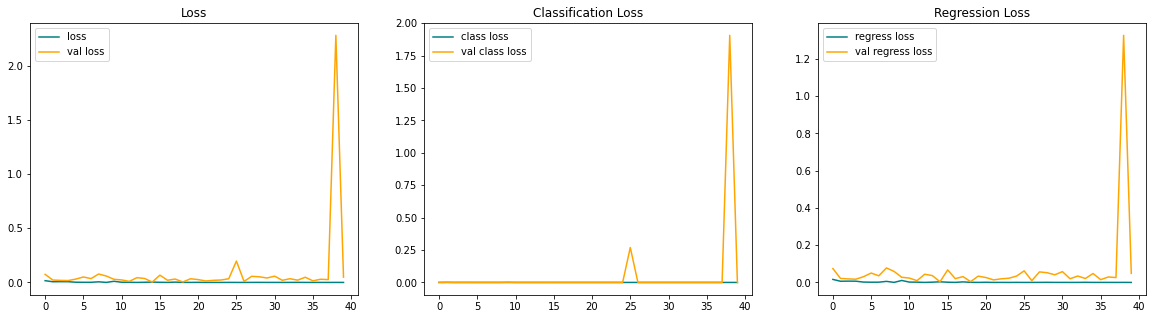

In [93]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# 11. Make Predictions

### 11.1 Make Predictions on Test Set

In [94]:
test_data = test.as_numpy_iterator()

In [105]:
test_sample = test_data.next()

In [106]:
yhat = facetracker.predict(test_sample[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


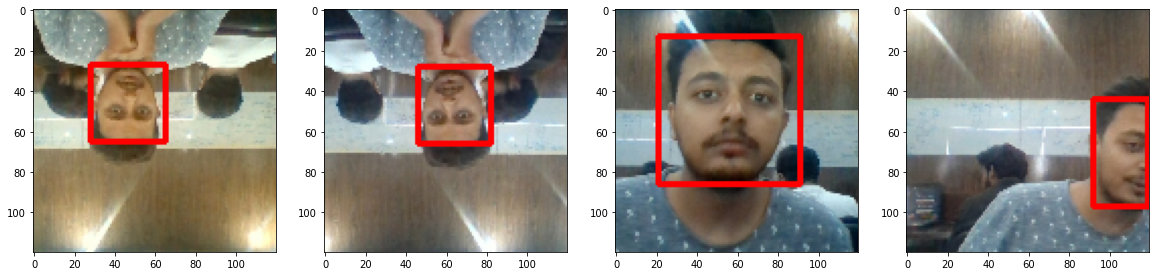

In [107]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

### 11.2 Save the Model

In [98]:
from tensorflow.keras.models import load_model

In [ ]:
!curl 

In [1]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [101]:
facetracker.save('facetracker.h5')

In [100]:
facetracker = load_model('facetracker.h5')

### 11.3 Real Time Detection

In [109]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()